In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from scipy import stats

data = pd.read_csv('Cepheids_DATA_errMVerrP.csv')
# Apply cut for significant r detection
data.head()


,MV,MV_err,LogP,LogP_err
0,1.25,0.50,0.17,0.07
1,5.20,0.60,0.05,0.01
2,-1.58,0.15,0.42,0.02
3,-1.93,0.13,0.42,0.07
4,-2.21,0.12,0.69,0.02


In [3]:
data.describe()

,MV,MV_err,LogP,LogP_err
count,162.000000,162.000000,162.000000,162.000000
mean,-3.594136,0.098333,0.812222,0.032593
std,1.072114,0.051827,0.287515,0.021857
min,-6.080000,0.080000,0.050000,0.010000
25%,-4.090000,0.090000,0.602500,0.020000
50%,-3.655000,0.090000,0.800000,0.020000
75%,-3.192500,0.100000,0.990000,0.057500
max,5.200000,0.600000,1.620000,0.070000


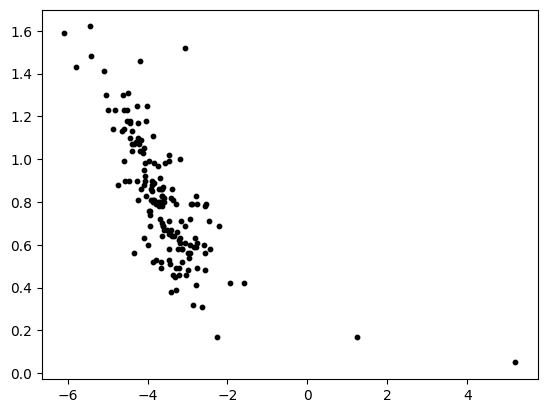

In [5]:
plt.scatter(data['MV'], data['LogP'], marker='o', color='k', s=10) 


I think we  need another plot excluding outliers.


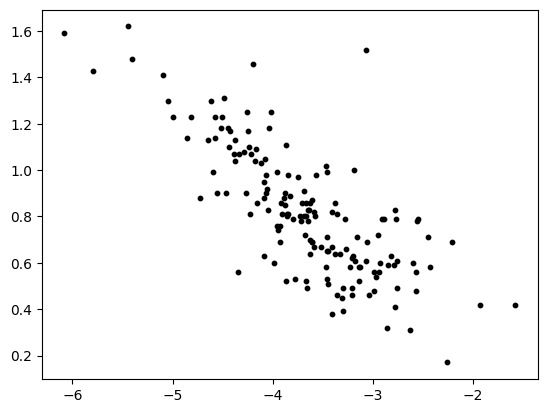

In [7]:
plt.scatter(data[data['MV']<0]['MV'], data[data['MV']<0]['LogP'], marker='o', color='k', s=10) 

First a linear regression:

In [8]:
from pymc import Model, Normal, Gamma, find_MAP
x = data['LogP']
x_err = data['LogP_err']
y = data['MV']
y_err = data['MV_err']
basic_model = Model()
with basic_model:
    ## priors for unknown model parameters
    Beta = Normal('beta',mu=0,tau=1./10, shape=2)
    precision = Gamma('precision', alpha=1, beta=1)
    
    mu = Beta[0] + Beta[1]*x
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)

In [10]:
map_estimate = find_MAP(model=basic_model)

In [11]:
map_estimate

{'beta': array([-1.49294368, -2.5862834 ]),
 'precision_log__': array(0.50663884),
 'precision': array(1.65970328)}

In [12]:
# Initialize random number generator
RANDOM_SEED = 5731
rng = np.random.default_rng(RANDOM_SEED)

with basic_model:
    start = find_MAP() 

    # draw 1000 posterior samples
    trace = pm.sample( start=start,return_inferencedata=True)

/tmp/ipykernel_26520/4182206176.py:9: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample( start=start,return_inferencedata=True)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [13]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [14]:
trace.posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 1000, beta_dim_0: 2)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (chain, draw, beta_dim_0) float64 -1.339 -2.844 ... -1.647 -2.41
    precision   (chain, draw) float64 1.637 1.652 1.743 ... 1.752 1.622 1.918
Attributes:
    created_at:                 2022-12-02T03:18:48.088600
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              7.535939693450928
    tuning_steps:               1000

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,names
beta[0],-1.483,0.180,-1.802,-1.123,0.005,0.003,1355.0,1766.0,1.0,Intercept
beta[1],-2.598,0.209,-2.988,-2.214,0.006,0.004,1337.0,1697.0,1.0,LogP
precision,1.666,0.181,1.332,2.000,0.004,0.003,2218.0,1916.0,1.0,Precision


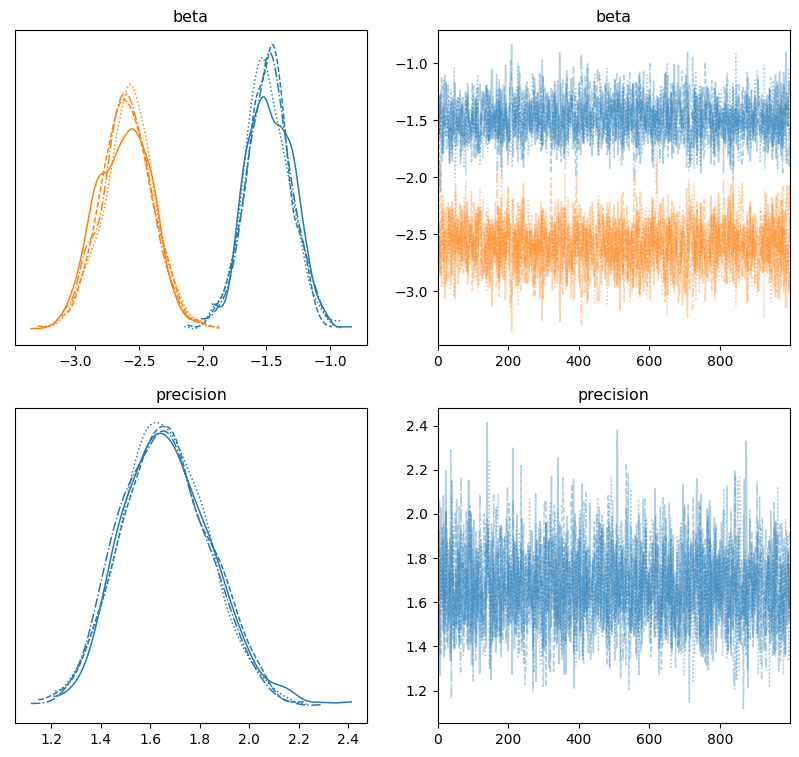

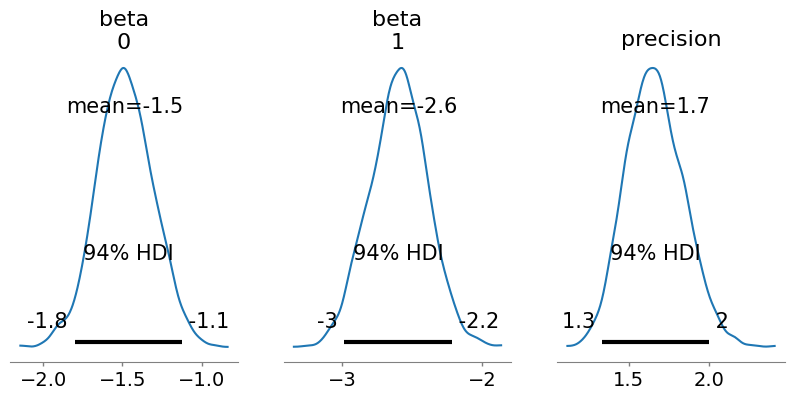

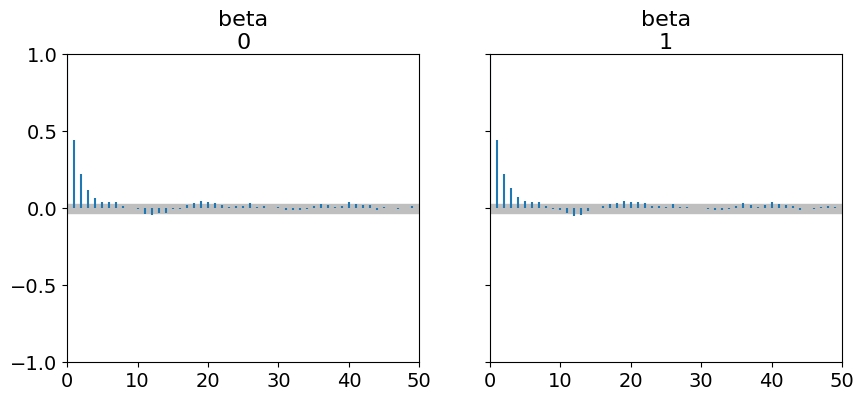

In [16]:
ts = az.summary(trace)
ts['names'] = ['Intercept','LogP','Precision']
display(ts)
az.plot_trace(trace,
              figsize=(10, 9));
plt.show()

az.plot_posterior(trace, figsize=(10, 4));
plt.show();

az.plot_autocorr(trace, var_names=['beta'], filter_vars="like",  max_lag=50,combined=True,figsize=(10, 4))
plt.show();

The acf plots are not the best but are close to zero after lag 10

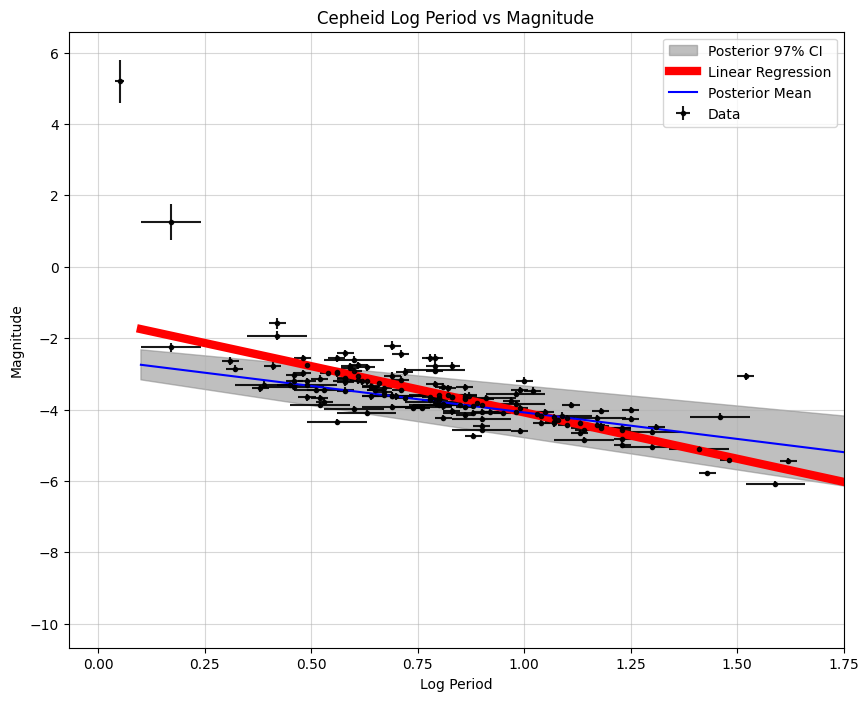

In [20]:
line = lambda m,x,b: m*x + b

sortedP = np.linspace(data['LogP'].min()*2,data['LogP'].max()*2,1000)
## fit the data with a linear regression with np.polyfit
m, b = np.polyfit(data['LogP'], data['MV'], 1) ## not sorted here
estimated_MV = line(m,sortedP,b)

## estimate fit with posterior 
m_mean = line(ts['mean'][0],sortedP,ts['mean'][1])
m_03 = line(ts['hdi_3%'][0],sortedP,ts['hdi_3%'][1])
m_97 = line(ts['hdi_97%'][0],sortedP,ts['hdi_97%'][1])

## plot the log period vs magnitude with errors for both
fig, ax = plt.subplots(figsize=(10,8), facecolor='white')
ax.errorbar(data['LogP'], data['MV'], xerr=data['LogP_err'], yerr=data['MV_err'], 
            fmt='o', markersize=3, color='black', alpha=0.9, label='Data')

## plot the 97% confidence interval
ax.fill_between(sortedP, m_03, m_97, color='grey', alpha=0.5, label='Posterior 97% CI')

## now plot the estimated magnitude over top of it
ax.plot(sortedP, estimated_MV, 
        lw=6, color='red', label='Linear Regression')

## plot the mean of the posterior distribution

ax.plot(sortedP, m_mean, color='blue', label='Posterior Mean')



## styling
# ax.set_xlim(df['LogP'].min()*1.1,df['LogP'].max()*1.1)
ax.set_xlim(-0.07,1.75)
ax.set_xlabel('Log Period')
ax.set_ylabel('Magnitude')
ax.grid(alpha=0.5)
ax.set_title('Cepheid Log Period vs Magnitude')
ax.legend()
plt.show();